In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import xgboost as xgb

# data part
## original data

In [4]:
data0 = pd.read_csv("phone_5g_sale_data-20210528.csv")
term_svc_dict = {'4G终端':0, '5G终端':1}
data0['term_svc'] = data0['term_svc'].apply(lambda x: term_svc_dict[x])

data0['gender'] = data0['gender'].astype(str)
data0['msisdn'] = data0['msisdn'].astype(str)
data0['apps'] = data0['apps'].astype(int)

print(data0.head())
print(data0.dtypes)

        msisdn  apps  social_days  social_durition  social_traff  game_days  \
0  15609769599    26            6              777       4361734          0   
1  17697389231    33            7             2005      94794528          0   
2  18697294282    41            7            15659     884812544          0   
3  15597013886    70            7            17607     601609856          0   
4  13119732278    25            7             1069       1881998          0   

   game_durition  game_traff  shop_days  shop_durition  ...  video_traff  age  \
0              0           0          1              0  ...        47086   36   
1              0           0          5           1000  ...       108552   41   
2              0           0          5            743  ...       114783   51   
3              0           0          4           1165  ...        12446   47   
4              0           0          2             55  ...       488754   34   

   gender  net_type  month_fee overdue

## continuous data

In [5]:
data0_continuous = data0.drop(['msisdn', 'net_type', 'gender', 'phone_company'], axis = 1)

std_c = []
for i in range(0, data0_continuous.shape[1]):
    a = data0_continuous.iloc[:, i].std()
    std_c.append(a)

mean_c = []
for i in range(0, data0_continuous.shape[1]):
    a = data0_continuous.iloc[:, i].mean()
    mean_c.append(a)
    
iqr_c = []
lower_c = []
higher_c = []
for i in range(0, data0_continuous.shape[1]):
    lower = np.percentile(data0_continuous.iloc[:, i], 25, interpolation = 'midpoint')
    higher = np.percentile(data0_continuous.iloc[:, i], 75, interpolation = 'midpoint')
    iqr = lower + higher
    iqr_c.append(iqr)
    lower_c.append(lower)
    higher_c.append(higher)

data0_continuous_nol = data0_continuous
for i in range(0, data0_continuous.shape[1]):
    the_min = mean_c[i] - 3 * std_c[i]
    the_max = mean_c[i] + 4 * std_c[i]
    data0_continuous_nol = data0_continuous_nol[
        (data0_continuous_nol.iloc[:, i] >= the_min) 
        & (data0_continuous_nol.iloc[:, i] <= the_max)]

print(data0.shape)
print(data0_continuous.shape)
print(data0_continuous_nol.shape)
print(data0_continuous_nol.describe())

(691100, 23)
(691100, 19)
(626470, 19)
                apps    social_days  social_durition  social_traff  \
count  626470.000000  626470.000000    626470.000000  6.264700e+05   
mean       48.376179       6.656616     20088.182821  6.851437e+08   
std        19.344726       0.759631     24771.763322  8.936294e+08   
min         1.000000       3.000000         0.000000  2.442000e+03   
25%        34.000000       7.000000      2858.000000  4.905621e+07   
50%        47.000000       7.000000     10544.000000  3.260103e+08   
75%        62.000000       7.000000     27928.000000  9.761960e+08   
max       130.000000       7.000000    150629.000000  5.258260e+09   

           game_days  game_durition    game_traff      shop_days  \
count  626470.000000  626470.000000  6.264700e+05  626470.000000   
mean        0.605199      45.944240  2.675854e+06       3.724470   
std         1.213870     212.811539  1.324939e+07       1.537559   
min         0.000000       0.000000  0.000000e+00       0.

In [ ]:
data0_continuous_nol.describe()

## categorical data

In [6]:
net_type = pd.get_dummies(data0['net_type'])
gender = pd.get_dummies(data0['gender'])
gender = gender.rename(columns = {'1': 'male', '2':'female'})
phone_company = pd.get_dummies(data0['phone_company'])

data0_categorical = df1 = pd.concat([net_type, gender, phone_company], axis = 1)

print(data0_categorical)

        4G  5G  male  female  1米  26.0  360  360JILUYI  5GHYUN  8848  ...  锤子  \
0        1   0     1       0   0     0    0          0       0     0  ...   0   
1        1   0     1       0   0     0    0          0       0     0  ...   0   
2        1   0     0       1   0     0    0          0       0     0  ...   0   
3        1   0     0       1   0     0    0          0       0     0  ...   0   
4        1   0     1       0   0     0    0          0       0     0  ...   0   
...     ..  ..   ...     ...  ..   ...  ...        ...     ...   ...  ...  ..   
691095   1   0     1       0   0     0    0          0       0     0  ...   0   
691096   1   0     0       1   0     0    0          0       0     0  ...   0   
691097   1   0     0       1   0     0    0          0       0     0  ...   0   
691098   1   0     1       0   0     0    0          0       0     0  ...   0   
691099   1   0     0       1   0     0    0          0       0     0  ...   0   

        长虹  阿巴町  青橙  飞利浦  首

# xgboost part
## train data

In [7]:
data_xgb = pd.concat([data0_continuous_nol, data0_categorical], axis = 1)
data_xgb = data_xgb.drop('phone_used_months', axis=1)
print(data_xgb.columns.values.tolist())

data_xgb_5g = data_xgb[data_xgb['term_svc'] == 1]
data_xgb_4g = data_xgb[data_xgb['term_svc'] == 0]

data_xgb_4g_sample_1 = data_xgb_4g.sample(n = 1*len(data_xgb_5g), replace = False, random_state = 1)
data_xgb_4g_sample_2 = data_xgb_4g.sample(n = 1*len(data_xgb_5g), replace = False, random_state = 2)
data_xgb_4g_sample_3 = data_xgb_4g.sample(n = 1*len(data_xgb_5g), replace = False, random_state = 3)

data_xgb_train_1 = data_xgb_5g.append(data_xgb_4g_sample_1, ignore_index = True)
data_xgb_train_2 = data_xgb_5g.append(data_xgb_4g_sample_2, ignore_index = True)
data_xgb_train_3 = data_xgb_5g.append(data_xgb_4g_sample_3, ignore_index = True)

print(len(data_xgb_train_1), len(data_xgb_train_2), len(data_xgb_train_3))

['apps', 'social_days', 'social_durition', 'social_traff', 'game_days', 'game_durition', 'game_traff', 'shop_days', 'shop_durition', 'shop_traff', 'video_days', 'video_durition', 'video_traff', 'age', 'month_fee', 'overdue_owe', 'term_svc', 'phones_owned', '4G', '5G', 'male', 'female', '1米', '26.0', '360', '360JILUYI', '5GHYUN', '8848', 'AIR', 'ALCATEL', 'ALDDNG', 'ALEKA', 'ALPINE', 'ANGELCARE', 'ARTIMEN', 'ATMAN', 'BADILONG', 'BEIDOUTIANHUI', 'BENTENG', 'BLACKBERRY', 'BROADMOBI', 'CAREPRO', 'COMBA', 'COOL', 'DFYOU', 'DOOGEE', 'DUSHULANG', 'E人E本', 'FEIYUESHIDAI', 'FIBERHOME', 'FIBOCOM', 'FIGI', 'FORGE', 'FORTUNE', 'FRUITFANS', 'GEMTEK', 'GOOGLE', 'GOSUNCN', 'HERO', 'HIKVISION', 'HOJY', 'HOSWN', 'HOT', 'HUAZHENGYISHANG', 'HUBAOXING', 'IFLYTEK', 'ILEJA', 'IMOO', 'IQOO', 'IVVI', 'IWINGS', 'JUANMENG', 'KAICOM', 'KK', 'KRETA', 'KUYI', 'LANXIAOBAN', 'LEKEER', 'LG', 'LIEBAOYIDONG', 'LOKMAT', 'LONGSUNG', 'LQ', 'LYNQ', 'M', 'MAILONG', 'MAISUN', 'MEIIGOO', 'MIJU', 'MIMITOOU', 'MLLED', 'MOBVOI', 

In [8]:
len(data_xgb_5g)
#len(data_xgb_4g)

124529

## model

In [9]:
y1 = data_xgb_train_1['term_svc']
x1 = data_xgb_train_1.drop(['term_svc'],  axis = 1)
y2 = data_xgb_train_2['term_svc']
x2 = data_xgb_train_2.drop(['term_svc'],  axis = 1)
y3 = data_xgb_train_3['term_svc']
x3 = data_xgb_train_3.drop(['term_svc'],  axis = 1)

X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state = 1)
X2_train, X2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.3, random_state = 2)
X3_train, X3_test, y3_train, y3_test = train_test_split(x3, y3, test_size = 0.3, random_state = 3)

dtrain1 = xgb.DMatrix(X1_train, label= y1_train, enable_categorical=True)
dtest1 = xgb.DMatrix(X1_test, enable_categorical=True)
watchlist1 = [(dtrain1, 'train')]

dtrain2 = xgb.DMatrix(X2_train, label= y2_train, enable_categorical=True)
dtest2 = xgb.DMatrix(X2_test, enable_categorical=True)
watchlist2 = [(dtrain2, 'train')]

dtrain3 = xgb.DMatrix(X3_train, label= y3_train, enable_categorical=True)
dtest3 = xgb.DMatrix(X3_test, enable_categorical=True)
watchlist3 = [(dtrain1, 'train')]

params = {'booster':'gbtree', 
          'objective': 'binary:logistic',
          'eval_metric':'auc',
          'max_depth': 6,
          'lambda': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'min_child_weight': 1,
          'eta': 0.2,
          'seed': 0,
          'nthread': 8,
          'gamma': 0}

bst1 = xgb.train(params, dtrain1, num_boost_round = 300, evals = watchlist1)
y1pred = bst1.predict(dtest1)
bst2 = xgb.train(params, dtrain2, num_boost_round = 300, evals = watchlist2)
y2pred = bst2.predict(dtest2)
bst3 = xgb.train(params, dtrain3, num_boost_round = 300, evals = watchlist3)
y3pred = bst3.predict(dtest3)

y1_pred = (y1pred >= 0.5)*1
print ('Precesion: %.4f' %metrics.precision_score(y1_test, y1_pred))
print ('Recall: %.4f' %metrics.recall_score(y1_test,y1_pred))
print ('F1-score: %.4f' %metrics.f1_score(y1_test,y1_pred))
print ('Accuracy: %.4f' %metrics.accuracy_score(y1_test,y1_pred))
print ('AUC: %.4f' %metrics.roc_auc_score(y1_test,y1pred))

y2_pred = (y2pred >= 0.5)*1
print ('Precesion: %.4f' %metrics.precision_score(y2_test, y2_pred))
print ('Recall: %.4f' % metrics.recall_score(y2_test,y2_pred))
print ('F1-score: %.4f' %metrics.f1_score(y2_test,y2_pred))
print ('Accuracy: %.4f' % metrics.accuracy_score(y2_test,y2_pred))
print ('AUC: %.4f' % metrics.roc_auc_score(y2_test,y2pred))

y3_pred = (y3pred >= 0.5)*1
print ('Precesion: %.4f' %metrics.precision_score(y3_test, y3_pred))
print ('Recall: %.4f' % metrics.recall_score(y3_test,y3_pred))
print ('F1-score: %.4f' %metrics.f1_score(y3_test,y3_pred))
print ('Accuracy: %.4f' % metrics.accuracy_score(y3_test,y3_pred))
print ('AUC: %.4f' % metrics.roc_auc_score(y3_test,y3pred))

[0]	train-auc:0.74752
[1]	train-auc:0.75197
[2]	train-auc:0.75536
[3]	train-auc:0.75686
[4]	train-auc:0.75915
[5]	train-auc:0.76043
[6]	train-auc:0.76343
[7]	train-auc:0.76612
[8]	train-auc:0.76790
[9]	train-auc:0.76959
[10]	train-auc:0.77091
[11]	train-auc:0.77193
[12]	train-auc:0.77314
[13]	train-auc:0.77400
[14]	train-auc:0.77587
[15]	train-auc:0.77740
[16]	train-auc:0.77787
[17]	train-auc:0.77860
[18]	train-auc:0.77964
[19]	train-auc:0.78145
[20]	train-auc:0.78231
[21]	train-auc:0.78309
[22]	train-auc:0.78494
[23]	train-auc:0.78545
[24]	train-auc:0.78590
[25]	train-auc:0.78636
[26]	train-auc:0.78686
[27]	train-auc:0.78717
[28]	train-auc:0.78774
[29]	train-auc:0.78867
[30]	train-auc:0.78968
[31]	train-auc:0.78987
[32]	train-auc:0.79017
[33]	train-auc:0.79132
[34]	train-auc:0.79171
[35]	train-auc:0.79181
[36]	train-auc:0.79215
[37]	train-auc:0.79232
[38]	train-auc:0.79323
[39]	train-auc:0.79340
[40]	train-auc:0.79371
[41]	train-auc:0.79449
[42]	train-auc:0.79507
[43]	train-auc:0.7953

[49]	train-auc:0.79651
[50]	train-auc:0.79716
[51]	train-auc:0.79720
[52]	train-auc:0.79756
[53]	train-auc:0.79761
[54]	train-auc:0.79780
[55]	train-auc:0.79785
[56]	train-auc:0.79812
[57]	train-auc:0.79818
[58]	train-auc:0.79862
[59]	train-auc:0.79897
[60]	train-auc:0.79902
[61]	train-auc:0.79904
[62]	train-auc:0.79950
[63]	train-auc:0.80010
[64]	train-auc:0.80036
[65]	train-auc:0.80068
[66]	train-auc:0.80080
[67]	train-auc:0.80165
[68]	train-auc:0.80228
[69]	train-auc:0.80272
[70]	train-auc:0.80275
[71]	train-auc:0.80306
[72]	train-auc:0.80359
[73]	train-auc:0.80387
[74]	train-auc:0.80404
[75]	train-auc:0.80407
[76]	train-auc:0.80420
[77]	train-auc:0.80422
[78]	train-auc:0.80450
[79]	train-auc:0.80453
[80]	train-auc:0.80455
[81]	train-auc:0.80482
[82]	train-auc:0.80495
[83]	train-auc:0.80499
[84]	train-auc:0.80501
[85]	train-auc:0.80545
[86]	train-auc:0.80558
[87]	train-auc:0.80572
[88]	train-auc:0.80597
[89]	train-auc:0.80639
[90]	train-auc:0.80660
[91]	train-auc:0.80663
[92]	train-

[97]	train-auc:0.79567
[98]	train-auc:0.79589
[99]	train-auc:0.79627
[100]	train-auc:0.79643
[101]	train-auc:0.79649
[102]	train-auc:0.79671
[103]	train-auc:0.79679
[104]	train-auc:0.79681
[105]	train-auc:0.79688
[106]	train-auc:0.79705
[107]	train-auc:0.79724
[108]	train-auc:0.79732
[109]	train-auc:0.79733
[110]	train-auc:0.79737
[111]	train-auc:0.79752
[112]	train-auc:0.79763
[113]	train-auc:0.79789
[114]	train-auc:0.79826
[115]	train-auc:0.79861
[116]	train-auc:0.79870
[117]	train-auc:0.79874
[118]	train-auc:0.79884
[119]	train-auc:0.79892
[120]	train-auc:0.79893
[121]	train-auc:0.79894
[122]	train-auc:0.79903
[123]	train-auc:0.79907
[124]	train-auc:0.79908
[125]	train-auc:0.79921
[126]	train-auc:0.79927
[127]	train-auc:0.79927
[128]	train-auc:0.79928
[129]	train-auc:0.79939
[130]	train-auc:0.79950
[131]	train-auc:0.79963
[132]	train-auc:0.79974
[133]	train-auc:0.79983
[134]	train-auc:0.80012
[135]	train-auc:0.80024
[136]	train-auc:0.80028
[137]	train-auc:0.80045
[138]	train-auc:0.8

## feature importance

D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 30005 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24847 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21162 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 27604 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20122 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-

D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 30005 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24847 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 21162 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 27604 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 20122 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\mat

D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29632 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 33529 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 26524 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32500 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 27779 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 20026 missing from current font.
  font.set_text(s, 0, flags=flags)


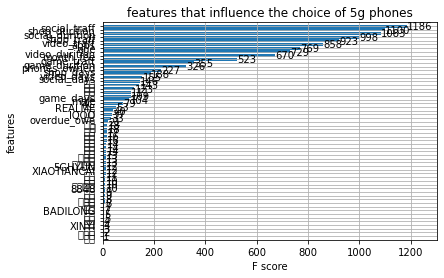

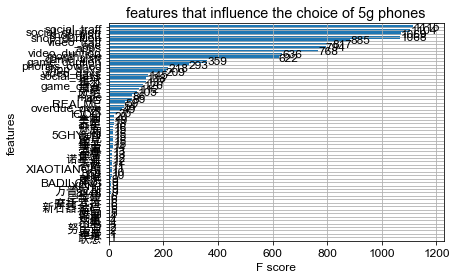

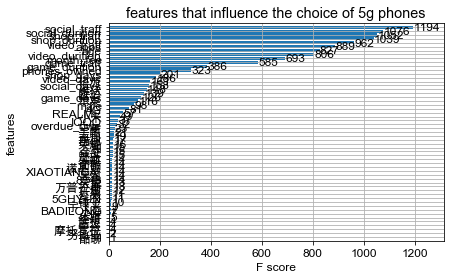

In [10]:
xgb.plot_importance(bst1,height=0.8,title='features that influence the choice of 5g phones', ylabel='features')
plt.rc('font', family='Arial Unicode MS', size=12)
plt.show()

xgb.plot_importance(bst2,height=0.8,title='features that influence the choice of 5g phones', ylabel='features')
plt.rc('font', family='Arial Unicode MS', size=12)
plt.show()

xgb.plot_importance(bst3,height=0.8,title='features that influence the choice of 5g phones', ylabel='features')
plt.rc('font', family='Arial Unicode MS', size=12)
plt.show()

## result-4g

In [11]:
#data_xgb recall:
#data_xgb = pd.concat([data0_continuous_nol, data0_categorical], axis = 1)
#data_xgb = data_xgb.drop('phone_used_months', axis=1)
#data_xgb_4g = data_xgb[data_xgb['term_svc'] == 0]
data_xgb_4g_result = data_xgb_4g.drop(['term_svc'],  axis = 1)

dtrain1_4g_result = xgb.DMatrix(data_xgb_4g_result, enable_categorical = True)
result1_4g = bst1.predict(dtrain1_4g_result)

dtrain2_4g_result = xgb.DMatrix(data_xgb_4g_result, enable_categorical = True)
result2_4g = bst2.predict(dtrain2_4g_result)

dtrain3_4g_result = xgb.DMatrix(data_xgb_4g_result, enable_categorical = True)
result3_4g = bst3.predict(dtrain3_4g_result)

result_sum_4g = result1_4g + result2_4g + result3_4g

print('result1_4g: ', sum(result1_4g > 0.6))
print('result2_4g: ', sum(result2_4g > 0.6))
print('result3_4g: ', sum(result3_4g > 0.6))
print('result_sum_4g: ', sum(result_sum_4g > 1.8))

MemoryError: Unable to allocate 609. MiB for an array with shape (501941, 318) and data type float32

# outcome

In [ ]:
data_use = pd.concat([data0_continuous, data0_categorical], axis = 1)
data_use = data_use.drop('phone_used_months', axis=1)
print(data_use.shape)

data_xgb_result = data_use.drop(['term_svc'],  axis = 1)

dtrain1_result = xgb.DMatrix(data_xgb_result, enable_categorical = True)
result1 = bst1.predict(dtrain1_result)

dtrain2_result = xgb.DMatrix(data_xgb_result, enable_categorical = True)
result2 = bst2.predict(dtrain2_result)

dtrain3_result = xgb.DMatrix(data_xgb_result, enable_categorical = True)
result3 = bst3.predict(dtrain3_result)

result_sum = result1 + result2 + result3

print('result1: ', sum(result1 > 0.6))
print('result2: ', sum(result2 > 0.6))
print('result3: ', sum(result3 > 0.6))
print('result_sum: ', sum(result_sum > 1.8))

In [ ]:
result1_df = pd.DataFrame(result1)
result1_df.columns = (['result1'])

result2_df = pd.DataFrame(result1)
result2_df.columns = (['result2'])

result3_df = pd.DataFrame(result1)
result3_df.columns = (['result3'])

data_outcome = pd.concat([data_use, result1_df, result2_df, result3_df], axis = 1)

print(data_outcome.head())
print(data_outcome.dtypes)

In [ ]:
data_outcome.to_csv(r"phone_5g_sale_data_outcome-20210610",encoding="utf-8-sig")